In [2]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_44970/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [4]:
backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends

backend_config = backend.configuration()

for key, value in backend_config.to_dict().items():
    print(key)
    print(value)

assert backend_config.open_pulse, "Backend doesn't support Pulse"
# Verifies whether Pulse is supported

dt = backend_config.dt # Example way of getting data on the backend
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds
backend_defaults = backend.defaults() 

backend.configuration().timing_constraints

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

# exponential function
def exponential(t, tau, a, offset):
    return a*np.exp(-t/tau)+offset

# fit an exponential function
def fit_exponential(ts, values):
    p0=[np.average(ts), 1, 0]
    return curve_fit(exponential, ts, values, p0=p0)

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

print(f"measure_instructions: {measure_instructions}")

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

print(f"measurement pulse: {measure_pulse}")
print(f"measurement delay: {measure_delay}")
print(f"x pulse: {x_pulse}")
print(f"sx pulse: {sx_pulse}")

backend_name
ibm_cairo
backend_version
1.3.5
n_qubits
27
basis_gates
['id', 'rz', 'sx', 'x', 'cx', 'reset']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26]]}, {'name': 'rz', 'parameters': ['theta'], 'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26]]}, {'name': 'sx', 'parameters': [], 'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26]]}, {'name': 'x', 'parameters': [], 'qasm_def': 'gate x q { U(pi, 0, pi) q; }', 'coupling_map': [[0], [1], [2], [3], [4

In [5]:
# Get Experiments from Helper Packages

from helper_funcs.helpers import integrated_fidelity_experiment, rr_freq_spec

2
2


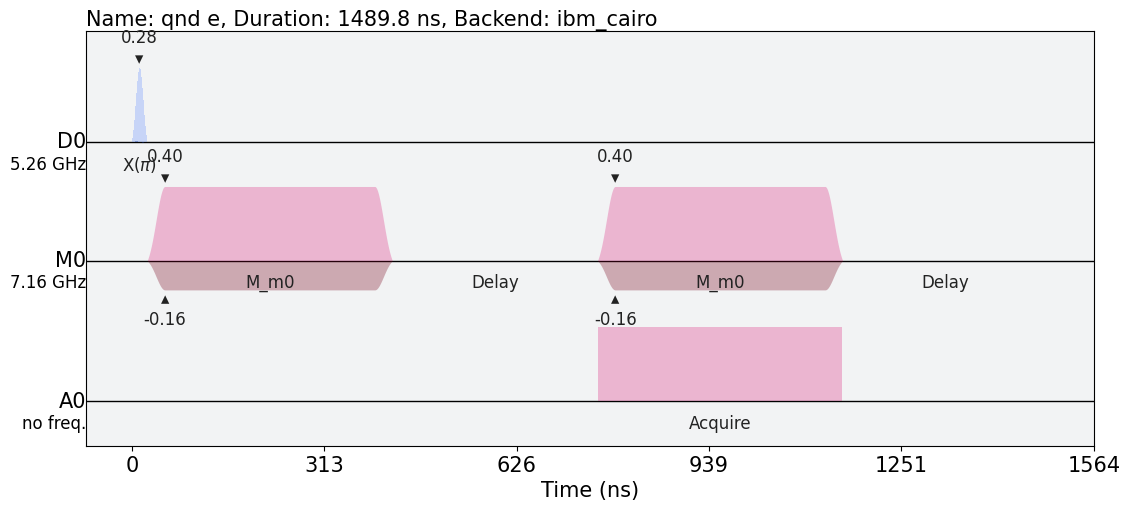

In [6]:
# Constructing a GE Experiment and a QND GE Experiment

ge_exp, qnd_exp = integrated_fidelity_experiment(qubit=qubit_0, backend=backend)

print(len(ge_exp))
print(len(qnd_exp))

qnd_exp[1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

101
101
{'Total Experiment Size': 202, 'Frequency Step Size (MHz)': 0.01, 'Frequency Span (MHz)': 1.0}


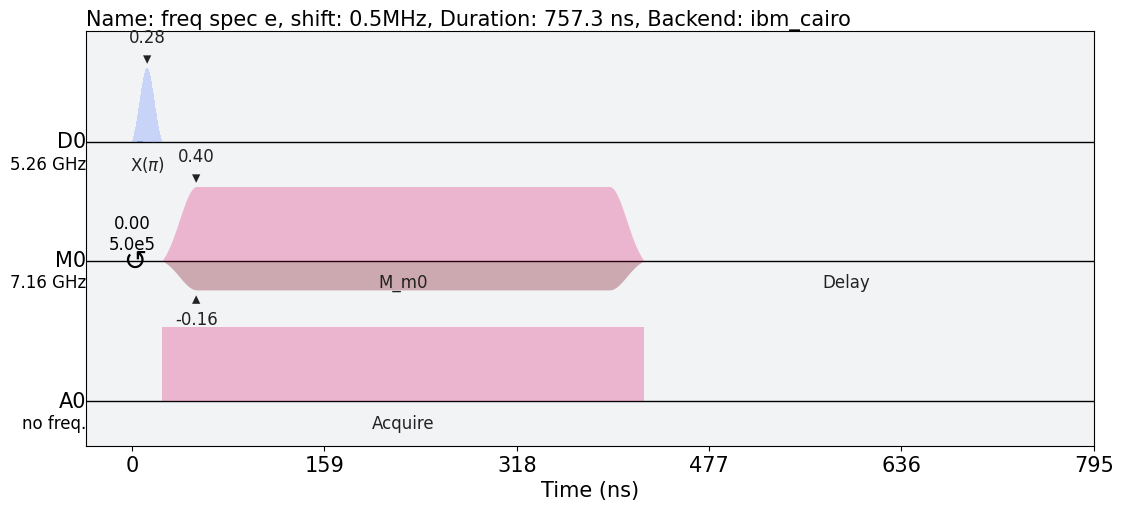

In [7]:
# Resonator Frequency Sweep Experiment

rr_freq_exp_g, rr_freq_exp_e, details = rr_freq_spec(
    qubit=qubit_0,
    backend=backend,
    freq_span=1.0 * MHz,
    num_experiments=101
)

print(len(rr_freq_exp_g))
print(len(rr_freq_exp_e))
print(details)

rr_freq_exp_e[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [8]:
# Constructing Qubit T1 Decay Experiment

from typing import Optional

def qubit_t1_exp(qubit: int, backend, min_delay: Optional[float] = 0.0, max_delay: Optional[float] = 100.0 * us, num_exp: Optional[int] = 101):
    delay_linspace = np.linspace(min_delay, max_delay, num_exp)

    t1_decay_exp = []

    for t1_delay in delay_linspace:
        t1_delay_dt = get_closest_multiple_of_16(get_dt_from(t1_delay))
        with pulse.build(backend=backend, default_alignment='sequential', name=f'Qubit T1, Delay: {int(t1_delay_dt * dt/us * 1e3) / 1e3}us') as t1_sched:
            qubit_chan = pulse.drive_channel(qubit)

            pulse.play(x_pulse, qubit_chan)
            pulse.delay(t1_delay_dt, qubit_chan)
            pulse.measure(qubit, pulse.RegisterSlot(qubit))
        t1_decay_exp.append(t1_sched)

    return t1_decay_exp

{'Total Experiment Size': 101, 'Frequency Step Size (us)': 1.0, 'Frequency Span (us)': 100.0}
101


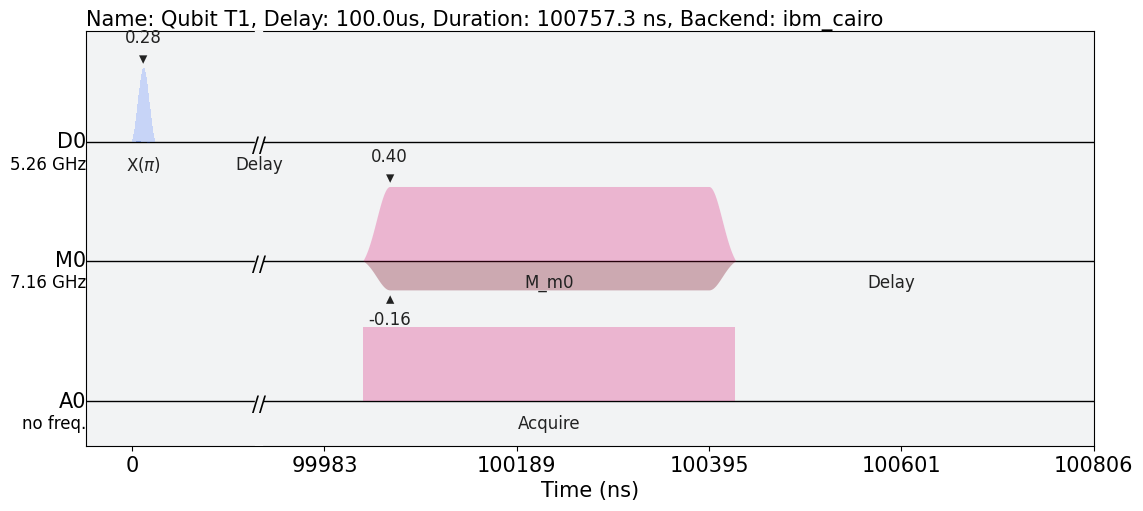

In [9]:
# Making T1 Decay Experiment

from helper_funcs.helpers import qubit_t1_exp

t1_decay_exp, t1_details = qubit_t1_exp(
    qubit=qubit_0,
    backend=backend,
    min_delay=0.0 * us,
    max_delay=100.0 * us,
    num_exp=101
)

print(t1_details)

print(len(t1_decay_exp))
t1_decay_exp[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)